In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [6]:
path = "data/2_1.txt"

ppg = pd.read_csv(path, sep="\t", header=None).T.dropna()

FileNotFoundError: [Errno 2] No such file or directory: 'data/2_1.txt'

In [4]:
ppg = np.asarray(ppg).ravel()

NameError: name 'ppg' is not defined

In [5]:
ppg

NameError: name 'ppg' is not defined

In [5]:
def mwa(ppg_signal, window=20):
    dataframe = pd.DataFrame(ppg_signal)
    dataframe.fillna(method='ffill', inplace=True) 
    signal_mwaved = dataframe.rolling(window, center=True, closed='both').mean()
    signal_mwaved = np.asarray(signal_mwaved).ravel()
    return signal_mwaved

In [6]:
mwa(ppg)

array([nan, nan, nan, ..., nan, nan, nan])

In [7]:
def moving_average_window(ppg_signal, window_size=20):
    smoothed_signal = np.zeros(len(ppg_signal))

    for i in range(len(ppg_signal)):
        start_index = max(0, i - window_size // 2)
        end_index = min(len(ppg_signal), i + window_size // 2 + 1)
        smoothed_signal[i] = np.mean(ppg_signal[start_index:end_index])

    return smoothed_signal

## SNR

The Signal-to-Noise Ratio (SNR) is a measure used to quantify the quality of a signal by comparing the strength of the signal to the level of background noise present in the signal. A higher SNR value indicates a better quality signal with less noise interference.


In [8]:
def calculate_snr(ppg_signal):

    signal_power = np.mean(ppg**2)
    noise_level = 0.1  
    noise_power = noise_level**2
    snr_db = 10 * np.log10(signal_power / noise_power)
    
    return snr_db

In [9]:
snr = calculate_snr(ppg)
print(f"{snr:.2f}")

86.25


## Perfusion Index 

In [10]:
def pi(ppg_signal):
    ac_component = np.max(ppg_signal) - np.min(ppg_signal)
    dc_component = np.mean(moving_average_window(ppg_signal))
    pi = ac_component / dc_component
    return pi

In [11]:
PI = round(pi(ppg), 2)
print(PI)

0.44


## Systolic Phase Duration
**with new moving average instead of mwa it reduced to 0.03 from 0.12**

In [12]:
def systolic_phase_duration(ppg_signal, fs):
    
    peaks, _ = find_peaks(moving_average_window(ppg_signal), height=np.mean(ppg_signal))
    systolic_phase_duration = len(peaks) / fs  # Convert number of samples to time duration
    return systolic_phase_duration

In [13]:
fs = 1000

In [14]:
sys_phase_dur = round(systolic_phase_duration(ppg, fs), 2)
print(sys_phase_dur)

0.03


## Ratio of Systolic to Diastolic Phase Duration

**with height=np.mean(ppg_signal) sys_to_dia = 0.15,<br/>
without height=np.mean(ppg_signal) sys_to_dia = 0.06**<br/>
**with moving_average_window instead of dropped to 0.02**

In [15]:
def sys_to_dia_ratio(ppg_signal, fs):
    peaks, _ = find_peaks(mwa(ppg_signal), height=np.mean(ppg_signal))
    systolic_phase_duration = len(peaks) / fs
    diastolic_phase_duration = len(ppg_signal) / fs - systolic_phase_duration
    ratio = systolic_phase_duration / diastolic_phase_duration
    return ratio

In [16]:
sys_to_dia = round(sys_to_dia_ratio(ppg, fs), 2)
print(sys_to_dia)

0.02


## Average Pulse Rate 

**compare given and calculated**

In [17]:
def avg_pulse_rate(ppg_signal, fs = 1000):
    
    peaks, _ = find_peaks(ppg_signal, height=np.mean(ppg), prominence=1, width=20)
    ibis = np.diff(peaks) / fs # Calculate time intervals between consecutive peaks
    pulse_rates = 60 / ibis  
    avg_pulse_rate = np.mean(pulse_rates)
    return avg_pulse_rate
                          
ibis = round(avg_pulse_rate(ppg), 2)
print(ibis)

98.78


mwa

In [18]:
def avg_pulse_rate(ppg_signal, fs = 1000):
    
    peaks, _ = find_peaks(mwa(ppg_signal), height=np.mean(ppg), prominence=1, width=20)
    ibis = np.diff(peaks) / fs # Calculate time intervals between consecutive peaks
    pulse_rates = 60 / ibis  
    avg_pulse_rate = np.mean(pulse_rates)
    return avg_pulse_rate
                          
ibis = round(avg_pulse_rate(ppg), 2)
print(ibis)

98.85


moving_average_window

In [19]:
def avg_pulse_rate(ppg_signal, fs = 1000):
    
    peaks, _ = find_peaks(moving_average_window(ppg_signal), height=np.mean(ppg), prominence=1, width=20)
    ibis = np.diff(peaks) / fs # Calculate time intervals between consecutive peaks
    pulse_rates = 60 / ibis  
    avg_pulse_rate = np.mean(pulse_rates)
    return avg_pulse_rate
                          
ibis = round(avg_pulse_rate(ppg), 2)
print(ibis)

98.85


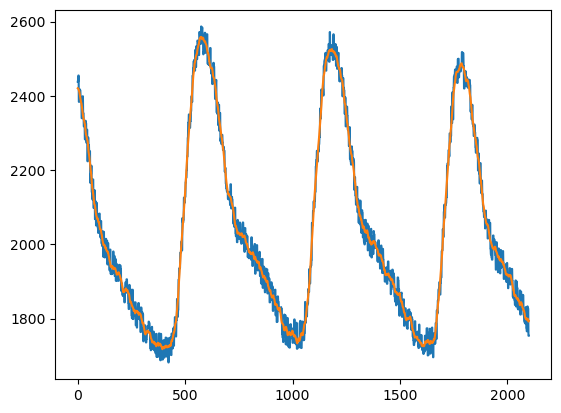

In [20]:
#plt.figure(figsize=(10,6))
plt.plot(ppg)
plt.plot(moving_average_window(ppg))

In [9]:
peaks, prop = find_peaks(moving_average_window(ppg), height=np.mean(ppg), prominence=1, width=20)
peaks, prop['left_bases']

(array([ 573, 1183, 1787]), array([ 394, 1022, 1611]))

In [10]:
def extract_first_cycle(ppg_signal):
    
    peaks, _ = find_peaks(moving_average_window(ppg_signal), height=np.mean(moving_average_window(ppg_signal)), prominence=1, width=20)
    first_start = prop['left_bases'][0]
    first_end = prop['left_bases'][1]
    first_cycle = moving_average_window(ppg_signal[first_start:first_end])
    return first_cycle

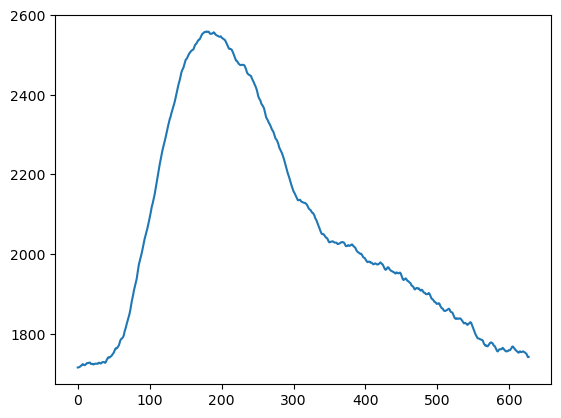

In [11]:
first_cycle = extract_first_cycle(ppg)
plt.plot(first_cycle)
plt.title('First Derivative of PPG Signal')
plt.show()

## Derivatives

first deriv

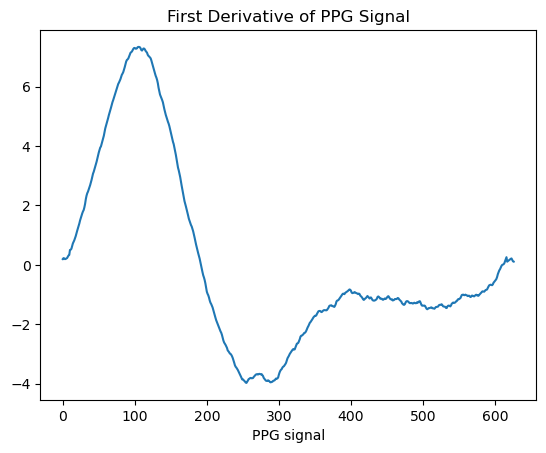

In [12]:
def first_derivative(ppg_signal):
    first_cycle = extract_first_cycle(moving_average_window(ppg_signal, window_size=100))
    first_derivative = np.diff(first_cycle)
    
    return first_derivative 
    
    
plt.plot(first_derivative(ppg))
plt.xlabel('PPG signal')
plt.title('First Derivative of PPG Signal')
plt.show()

second deriv

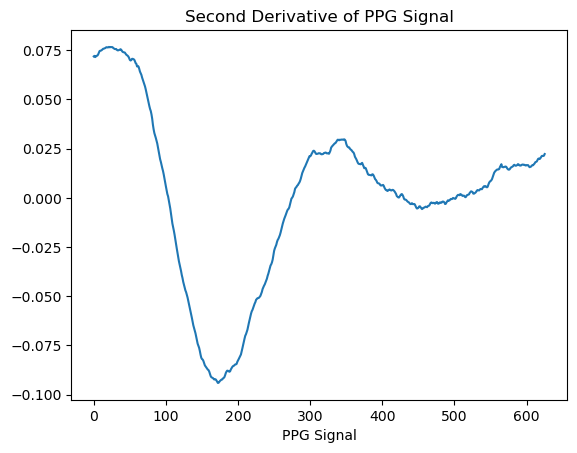

In [13]:
def second_derivative(ppg_signal):

    first_cycle = extract_first_cycle(moving_average_window(ppg_signal, window_size=100))
    first_derivative = np.diff(first_cycle)
    second_derivative = np.diff(first_derivative)
    
    return second_derivative
    
    
plt.plot(moving_average_window(second_derivative(ppg), window_size=100))
plt.xlabel('PPG Signal')
plt.title('Second Derivative of PPG Signal')
plt.show()

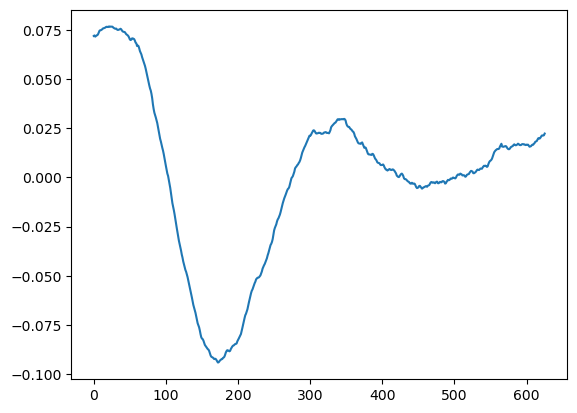

In [51]:
sec_deriv = moving_average_window(second_derivative(ppg), window_size=100)

peaks_deriv, prop_deriv = find_peaks(moving_average_window(sec_deriv, window_size=40), 
                                     height=np.mean(sec_deriv)
                                    )

peaks_deriv, prop_deriv
plt.plot(sec_deriv )

## Dicrotic notch and diastolic peak

In [18]:
def dic_notch (ppg_signal):

    peaks_deriv, prop_deriv = find_peaks(moving_average_window(sec_deriv, window_size=40), 
                                         height=np.mean(sec_deriv)
                                        )
    notch = peaks_deriv[3]
    
    return notch

In [60]:
def dia_peak (ppg_signal):
    
    peaks_deriv, prop_deriv = find_peaks(moving_average_window(sec_deriv, window_size=40), 
                                         height=np.mean(sec_deriv)
                                        )
    notch = peaks_deriv[3]
    end = peaks_deriv[4]
    peak = (notch + end) / 2
    #peak = np.mean(end, notch)
    
    return peak

In [61]:
diastole_peak = dia_peak(ppg)
diastole_peak

461.5

In [21]:
dic_notch(ppg)

340

In [46]:
def sec_deriv_smoothed(period):
    
    ppg = np.asarray(period).ravel()
    #period_squeezed = period.squeeze()
    averaged_cycle = (moving_average_window(ppg, window_size=100))
    first_derivative = np.diff(averaged_cycle)
    second_derivative = np.diff(first_derivative)
    sec_deriv_sm = moving_average_window(second_derivative,
                                               window_size=100)
    
    peaks_deriv, prop_deriv = find_peaks(moving_average_window(sec_deriv_sm),  
                                        height=np.mean(sec_deriv_sm)
                                        )
    
    return peaks_deriv, prop_deriv


peaks, properties = sec_deriv_smoothed(first_cycle)
peaks, properties


(array([ 28, 313, 341, 536, 564, 573, 588, 603]),
 {'peak_heights': array([0.07141391, 0.02276487, 0.02863887, 0.00640952, 0.01142272,
         0.01131735, 0.01115649, 0.01027116])})

In [63]:
def dia_peak_2(period):
    
    #ppg = np.asarray(period).ravel()
    ppg = period.squeeze()
    averaged_cycle = (moving_average_window(ppg, window_size=100))
    first_derivative = np.diff(averaged_cycle)
    second_derivative = np.diff(first_derivative)
    sec_deriv_sm = moving_average_window(second_derivative,
                                               window_size=100)
    
    peaks_deriv, prop_deriv = find_peaks(moving_average_window(sec_deriv_sm),  
                                        height=np.mean(sec_deriv_sm)
                                        )
    
    notch = peaks_deriv[2]
    end = peaks_deriv[3]
    peak = (notch + end) / 2
    
    return notch
    

# plt.plot(sec_deriv_smoothed(first_cycle))
# plt.plot(sec_deriv_smoothed(first_cycle))

diapeak = dia_peak_2(first_cycle)
diapeak

341

In [70]:
def diaPeak(period):
    
    #ppg = np.asarray(period).ravel()
    ppg = period.squeeze()
    averaged_cycle = (moving_average_window(ppg, window_size=100))
    first_derivative = np.diff(averaged_cycle)
    second_derivative = np.diff(first_derivative)
    sec_deriv_sm = moving_average_window(second_derivative,
                                               window_size=100)
    
    peaks_deriv, prop_deriv = find_peaks(moving_average_window(sec_deriv_sm),  
                                        height=np.mean(sec_deriv_sm)
                                        )
    dia_peak = (peaks_deriv[2] + peaks_deriv[3]) / 2
    
    return dia_peak

DP = diaPeak(first_cycle)
DP

438.5

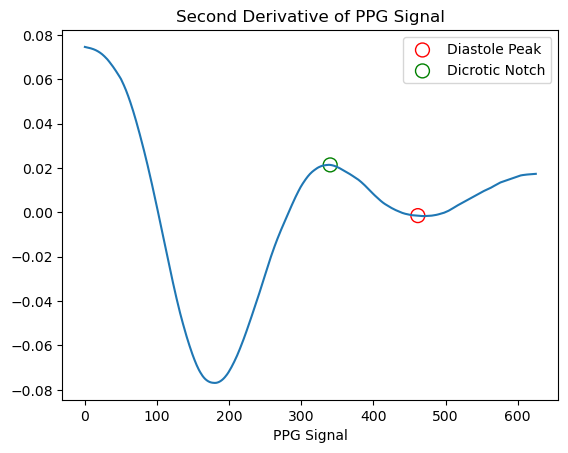

In [56]:
plt.plot(moving_average_window(sec_deriv, window_size=100))
plt.xlabel('PPG Signal')
plt.title('Second Derivative of PPG Signal')


change_points = np.where(np.diff(np.sign(sec_deriv)))[0]
plt.scatter(diastole_peak, moving_average_window(sec_deriv, window_size=100)[int(diastole_peak)],
            color='red',
            s=100, 
            marker='o', 
            facecolors='none', 
            edgecolors='red',
            label='Diastole Peak')

plt.scatter(dic_notch(ppg), moving_average_window(sec_deriv, window_size=100)[int(dic_notch(ppg))],
            color='red',
            s=100, 
            marker='o', 
            facecolors='none', 
            edgecolors='green',
            label='Dicrotic Notch')


plt.legend()
plt.show()


## PAT